# Miniproject 3: Landing on the Moon

## Introduction

### Description

Traditionally, reinforcement learning has operated on "tabular" state spaces, e.g. "State 1", "State 2", "State 3" etc. However, many important and interesting reinforcement learning problems (like moving robot arms or playing Atari games) are based on either continuous or very high-dimensional state spaces (like robot joint angles or pixels). Deep neural networks constitute one method for learning a value function or policy from continuous and high-dimensional observations. 

In this miniproject, you will teach an agent to play the Lunar Lander game from OpenAI Gym. The agent needs to learn how to land a lunar module safely on the surface of the moon. The state space is 8-dimensional and (mostly) continuous, consisting of the X and Y coordinates, the X and Y velocity, the angle, and the angular velocity of the lander, and two booleans indicating whether the left and right leg of the lander have landed on the moon.

The agent gets a reward of +100 for landing safely and -100 for crashing. In addition, it receives "shaping" rewards at every step. It receives positive rewards for moving closer to [0,0], decreasing in velocity, shifting to an upright angle and touching the lander legs on the moon. It receives negative rewards for moving away from the landing site, increasing in velocity, turning sideways, taking the lander legs off the moon and for using fuel (firing the thrusters). The best score an agent can achieve in an episode is about +250.

There are two versions of the task: one with discrete controls and one with continuous controls but we'll only work with the discrete version. In the discrete version, the agent can take one of four actions at each time step: [do nothing, fire engines left, fire engines right, fire engines down]. 

We will use Policy Gradient approaches (using the REINFORCE rule) to learn the task. In the previous miniproject, the network generates a probability distribution over the outputs, and is trained to maximize the probability of a specific target output given an observation (input). In Policy Gradient methods, the network generates a probability distribution over actions, and is trained to maximize expected future rewards given an observation.

### Prerequisites

- You need to install [OpenAI Gym](https://gym.openai.com/docs/) and Box2D in addition to [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/) in you environment. To do so just use the following commands:
  - source activate cs456env
  - pip install gym
  - pip install box2d-py
  
- You should know the concepts of "policy", "policy gradient", "REINFORCE", "REINFORCE with baseline". If you want to start and haven't seen these yet in class, read Sutton & Barto (2018) Chapter 13 (13.1-13.4).

### What you will learn

- You will learn how to implement a policy gradient neural network using the REINFORCE algorithm.
- You will learn how to implement baselines, including a learned value network.
- You will learn how to regularize a policy using entropy.

### Notes 
- Reinforcement learning is noisy! Normally one should average over multiple random seeds with the same parameters to really see the impact of a change to the model, but we won't do this due to time constraints. However, you should be able to see learning over time with every approach. If you don't see any improvement, or very unstable learning, double-check your model and try adjusting the learning rate.

- You may sometimes see "AssertionError: IsLocked() = False" after restarting your code. To fix this, reinitialize the environments by running the Gym Setup code below.

- You will not be marked on the episode movies. Please delete these movies before uploading your code.

### Evaluation criteria

The miniproject is marked out of 18, with a further mark breakdown in each question:
- Exercise 1: 7 points
- Exercise 2: 3 points
- Exercise 3: 3 points
- Exercise 4: 5 points

We may perform random tests of your code but will not rerun the whole notebook.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Your Names

Before you start, please enter your sciper number(s) in the field below; they are used to load the data.

In [2]:
sciper = {'student_1': 295304, 
          'student_2': 295304}
seed = sciper['student_1']+sciper['student_2']

## Setup

### Dependencies and constants

In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import logging
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, clear_output
from gym.envs.box2d.lunar_lander import heuristic

import keras
import tensorflow as tf
from tensorflow.contrib.distributions import Beta
from keras.models import Sequential
from keras.layers import Dense, Lambda
from keras.optimizers import Adam
from keras import backend as K

np.random.seed(seed)
tf.set_random_seed(seed*2)

Using TensorFlow backend.


### Gym Setup

Here we load the Reinforcement Learning environments from Gym.

We limit each episode to 500 steps so that we can train faster. 

In [4]:
gym.logger.setLevel(logging.ERROR)
discrete_env = gym.make('LunarLander-v2')
discrete_env._max_episode_steps = 500
discrete_env.seed(seed*3)
gym.logger.setLevel(logging.WARN)

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams["animation.html"] = "jshtml"

### Utilities

We include a function that lets you visualize an "episode" (i.e. a series of observations resulting from the actions that the agent took in the environment).

As well, we will use the "Results" class (a wrapper around a python dictionary) to store, save, load and plot your results. You can save your results to disk with results.save('filename') and reload them with Results(filename='filename'). Use results.pop(experiment_name) to delete an old experiment.

In [5]:
def AddValue(output_size, value):
    return Lambda(lambda x: x + value, output_shape=(output_size,))

def render(episode, env):
    
    fig = plt.figure()
    img = plt.imshow(env.render(mode='rgb_array'))
    plt.axis('off')

    def animate(i):
        img.set_data(episode[i])
        return img,

    anim = FuncAnimation(fig, animate, frames=len(episode), interval=24, blit=True)
    html = HTML(anim.to_jshtml())
    
    plt.close(fig)
    !rm None0000000.png
    
    return html

class Results(dict):
    
    def __init__(self, *args, **kwargs):
        if 'filename' in kwargs:
            data = np.load(kwargs['filename'])
            super().__init__(data)
        else:
            super().__init__(*args, **kwargs)
        self.new_key = None
        self.plot_keys = None
        self.ylim = None
        
    def __setitem__(self, key, value):
        super().__setitem__(key, value)
        self.new_key = key

    def plot(self, window):
        clear_output(wait=True)
        for key in self:
            #Ensure latest results are plotted on top
            if self.plot_keys is not None and key not in self.plot_keys:
                continue
            elif key == self.new_key:
                continue
            self.plot_smooth(key, window)
        if self.new_key is not None:
            self.plot_smooth(self.new_key, window)
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend(loc='lower right')
        if self.ylim is not None:
            plt.ylim(self.ylim)
        plt.show()
        
    def plot_smooth(self, key, window):
        if len(self[key]) == 0:
            plt.plot([], [], label=key)
            return None
        y = np.convolve(self[key], np.ones((window,))/window, mode='valid')
        x = np.linspace(window/2, len(self[key]) - window/2, len(y))
        plt.plot(x, y, label=key)
        
    def save(self, filename='results'):
        np.savez(filename, **self)

### Test runs

To get an idea of how the environment works, we'll plot an episode resulting from random actions at each point in time, and a "perfect" episode using a specially-designed function to land safely within the yellow flags. 

Please remove these plots before submitting the miniproject to reduce the file size.

In [6]:
def run_fixed_episode(env, policy):
    frames = []
    observation = env.reset()
    done = False
    while not done:
        frames.append(env.render(mode='rgb_array'))
        action = policy(env, observation)
        observation, reward, done, info = env.step(action)
    return frames
    
def random_policy(env, observation):
    return env.action_space.sample()

def heuristic_policy(env, observation):
    return heuristic(env.unwrapped, observation)

In [35]:
episode = run_fixed_episode(discrete_env, random_policy)
#render(episode, discrete_env)

In [ ]:
episode = run_fixed_episode(discrete_env, heuristic_policy)
render(episode, discrete_env)

## Experiment Loop

This is the method we will call to setup an experiment. Reinforcement learning usually operates on an Observe-Decide-Act cycle, as you can see below.

You don't need to add anything here; you will be working directly on the RL agent.

In [34]:
num_episodes = 1000

def run_experiment(experiment_name, env, num_episodes, policy_learning_rate = 0.001, value_learning_rate = 0.001, 
                   baseline=None, entropy_cost = 0, max_ent_cost = 0):

    #Initiate the learning agent
    agent = RLAgent(n_obs = env.observation_space.shape[0], action_space = env.action_space,
                    policy_learning_rate = policy_learning_rate, value_learning_rate = value_learning_rate, 
                    discount=0.99, baseline = baseline, entropy_cost = entropy_cost, max_ent_cost = max_ent_cost)

    rewards = []
    all_episode_frames = []
    step = 0
    for episode in range(1, num_episodes+1):
    
        #Update results plot and occasionally store an episode movie
        episode_frames = None
        if episode % 10 == 0:
            results[experiment_name] = np.array(rewards)
            results.plot(10)
        if episode % 500 == 0:
            episode_frames = []
            
        #Reset the environment to a new episode
        observation = env.reset()
        episode_reward = 0

        while True:
        
            if episode_frames is not None:
                episode_frames.append(env.render(mode='rgb_array'))

            # 1. Decide on an action based on the observations
            action = agent.decide(observation)

            # 2. Take action in the environment
            next_observation, reward, done, info = env.step(action)
            episode_reward += reward

            # 3. Store the information returned from the environment for training
            agent.observe(observation, action, reward)

            # 4. When we reach a terminal state ("done"), use the observed episode to train the network
            if done:
                rewards.append(episode_reward)
                if episode_frames is not None:
                    all_episode_frames.append(episode_frames)
                agent.train()
                break

            # Reset for next step
            observation = next_observation
            step += 1
            
    return all_episode_frames, agent

## The Agent

Here we give the outline of a python class that will represent the reinforcement learning agent (along with its decision-making network). We'll modify this class to add additional methods and functionality throughout the course of the miniproject.


In [70]:
class RLAgent(object):
    
    def __init__(self, n_obs, action_space, policy_learning_rate, value_learning_rate, 
                 discount, baseline = None, entropy_cost = 0, max_ent_cost = 0):

        #We need the state and action dimensions to build the network
        self.n_obs = n_obs  
        self.n_act = action_space.n
        
        self.gamma = discount
        self.moving_baseline = None

        #Fill in the rest of the agent parameters to use in the methods below
        self.policy_learning_rate = policy_learning_rate
        self.value_learning_rate = value_learning_rate
        
        self.use_baseline = False
        self.use_adaptive_baseline = False
        if baseline == 'adaptive':
            self.use_adaptive_baseline = True
        elif baseline == 'simple':
            print("self.usebaseline is in effect")
            self.use_baseline = True

        
        self.model_policy = None
        #These lists stores the cumulative observations for this episode
        self.episode_observations, self.episode_actions, self.episode_rewards = [], [], []

        #Build the keras network
        self._build_network()

    def observe(self, state, action, reward):
        """ This function takes the observations the agent received from the environment and stores them
            in the lists above. """
        self.episode_observations.append(state)
        self.episode_actions.append(action)
        self.episode_rewards.append(reward)
        

        
        
        
    def decide(self, state):
        """ This function feeds the observed state to the network, which returns a distribution
            over possible actions. Sample an action from the distribution and return it."""
        state = np.expand_dims(state, axis=0)

        actions = self.model_policy.predict(state)[0]
        action = np.random.choice(range(actions.shape[0]), p=actions.ravel())
        return action

    def train(self):
        """ When this function is called, the accumulated observations, actions and discounted rewards from the
            current episode should be fed into the network and used for training. Use the _get_returns function 
            to first turn the episode rewards into discounted returns. """
        
        episode_steps = len(self.episode_observations)
        num_actions = 4
        inputs = np.asarray(self.episode_observations)
        targets = np.zeros((episode_steps, num_actions))
        
        discounted_rewards = self._get_returns()
        for t in range(episode_steps):
            targets[t, self.episode_actions[t]] = 1
        
        
        
        loss, _ = self.model_policy.train_on_batch(inputs, targets, sample_weight = discounted_rewards)
        self.episode_observations, self.episode_actions, self.episode_rewards = [], [], []
        

    def _get_returns(self):
        """ This function should process self.episode_rewards and return the discounted episode returns
            at each step in the episode, then optionally apply a baseline. Hint: work backwards."""
        discounted_episode_rewards = np.zeros_like(self.episode_rewards)
        cumulative = 0
        moving_average_vals, moving_average_size = [], 0
        
        for t in reversed(range(len(self.episode_rewards))):
            cumulative = cumulative * self.gamma + self.episode_rewards[t]
            
        
            if self.use_baseline:
                #moving average
                window_size = 20
                
                if moving_average_size < window_size:
                    moving_average_size += 1
                else:
                    moving_average_vals.pop(0)
                    
                moving_average_vals.append(cumulative)
                G_baselined = cumulative  - sum(moving_average_vals) / moving_average_size
                discounted_episode_rewards[t] = G_baselined * pow(self.gamma, t)
    
            elif self.use_adaptive_baseline:
                pass
            else:
                #without baseline
                discounted_episode_rewards[t] = pow(self.gamma, t) * cumulative


        discounted_episode_rewards -= np.mean(discounted_episode_rewards)
        discounted_episode_rewards /= np.std(discounted_episode_rewards)
        return discounted_episode_rewards
    

    def _build_network(self):
        """ This function should build the network that can then be called by decide and train. 
            The network takes observations as inputs and has a policy distribution as output."""
        optimizer_adam = Adam(lr=self.policy_learning_rate)
        model = Sequential()
        model.add(Dense(16, activation='relu', input_dim=8))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(4, activation='softmax'))
        model.compile(optimizer=optimizer_adam,
                      loss='categorical_crossentropy', metrics=['acc'])
        
        self.model_policy = model

## Exercise 1: REINFORCE with simple baseline

### Description

Implement the REINFORCE Policy Gradient algorithm using a deep neural network as a function approximator.

1. Implement the "observe" method of the RLAgent above.
2. Implement the "_build_network" method. Your network should take the 8-dimensional state space as input and output a softmax distribution over the 4 discrete actions. It should have 3 hidden layers with about 16 units each with ReLU activations. Use the REINFORCE loss function. HINT: Keras has a built-in "categorical cross-entropy" loss, and a "sample_weight" argument in fit/train_on_batch. Consider how these could be used together.
3. Implement the "decide", "train" and "_get_returns" methods using the inputs and outputs of your network. In "_get_returns", implement a baseline based on a moving average of the returns; it should only be in effect when the agent is constructed with the "use_baseline" keyword. In "train", use train_on_batch to form one minibatch from all the experiences in an episode. 
4. Try a few learning rates and pick the best one (the default for Adam is a good place to start). Run the functions below and include the resulting plots, with and without the baseline, for your chosen learning rate. 
5. Answer the question below in max. 1-2 sentence(s).

WARNING: Running any experiments with the same names (first argument in run_experiment) will cause your results to be overwritten. 

**Mark breakdown: 7 points total**
- 5 points for implementing and plotting basic REINFORCE with reasonable performance (i.e. a positive score) and answering the questions below.
- 2 points for implementing and plotting the simple baseline with reasonable performance.

### Solution

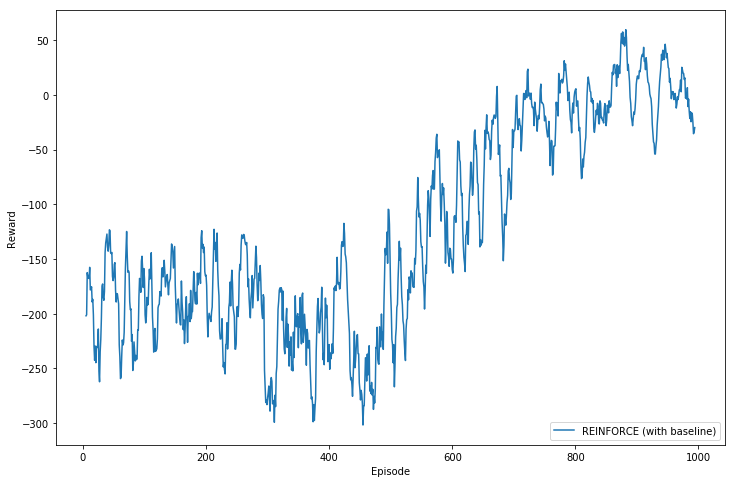

In [71]:
#Supply a filename here to load results from disk
results = Results()
policy_learning_rate = None
#_, _ = run_experiment("REINFORCE", discrete_env, num_episodes) #without baseline
episodes, _ = run_experiment("REINFORCE (with baseline)", discrete_env, num_episodes, #policy_learning_rate, 
                             baseline='simple') #simple baseline

In [22]:
render(episodes[-1], discrete_env)

NameError: name 'episodes' is not defined

**Question 1**: Why is it better to sample an action from the softmax distribution rather than just pick the action with highest probability? 

**Answer**:

**Question 2**: In the train method above we throw away the data from an episode after we use it to train the network (make sure that you do that). Why is it not a good idea to keep the old episodes in our data and train the policy network on both old and new data? (Note: Reusing data can still be possible but requires modifications to the REINFORCE algorithm we are using).

**Answer**:

## Exercise 2: Adaptive baseline
### Description

Add a second neural network to your model that learns an observations-dependent adaptive baseline and subtracts it from your discounted returns.

1. Modify the "_build_network" function of RLAgent to create a second "value network" when "adaptive" is passed for the baseline argument. The value network should have the same or similar structure as the policy network, without the softmax at the output.
3. In addition to training your policy network, train the value network on the Mean-Squared Error compared to the adjusted returns.
4. Train your policy network on R - b(s), i.e. the returns minus the adaptive baseline (the output of the value network). Your implementation should allow for a different learning rate for the value and policy network.
5. Try a few learning rates and plot all your best results together (without baseline, with simple baseline, with adaptive baseline). You may or may not be able to improve on the simple baseline! Return the trained model to use it in the next exercise.

TECHNICAL NOTE: Some textbooks may refer to this approach as "Actor-Critic", where the policy network is the "Actor" and the value network is the "Critic". Sutton and Barto (2018) suggest that Actor-Critic only applies when the discounted returns are bootstrapped from the value network output, as you saw in class. This can introduce instability in learning that needs to be addressed with more advanced techniques, so we won't use it for this miniproject. You can read more about state-of-the-art Actor-Critic approaches here: https://arxiv.org/pdf/1602.01783.pdf

**Mark breakdown: 3 points total**
- 3 points for implementing and plotting the adaptive baseline with the other two conditions, with reasonable performance (i.e. at least similar to the performance in Exercise 1).

### Solution

In [ ]:
value_learning_rate = None
episodes, d_model = run_experiment("REINFORCE (adaptive baseline)", discrete_env, num_episodes, policy_learning_rate, 
                                   value_learning_rate, baseline='adaptive')

In [ ]:
render(episodes[-1], discrete_env)

## Exercise 3: Visualizing the Value Function

### Description

Ideally, our value network should have learned to predict the relative values across the input space. We can test this by plotting the value prediction for different observations.

1. Write a function to plot the value network prediction across [x,y] space for given (constant) values of the other state variables. X is always in [-1,1], and Y generally lies in [-0.2,1], where the landing pad is at [0,0]. (plt.imshow, plt.title, and plt.colorbar can be useful)
2. Plot (with titles specifying the state variable combinations) the values for 5-6 combinations of the other 6 state variables, including [0,0,0,0,0,0]. The X and Y velocity are generally within [-1,1], the angle is in [-pi,pi] and the angular velocity lies roughly within [-3,3]. The last two inputs indicating whether the legs have touched the ground are 0 (False) or 1 (True). Include two combinations with (one of the) state variables out of these ranges. Use the same color bar limits across the graphs so that they can be compared easily. 
3. Answer the question below in max. 2-3 sentence(s).

**Mark breakdown: 3 points total**
- 2 points for the plots of the value function.
- 1 point for answering the question below.

### Solution

**Question**: Does your value map for the state variables combination [0,0,0,0,0,0] make sense? What about the value maps for the combinations with state variables out of the ranges above?

**Answer**:


## Exercise 4: Regularizing the Policy
### Description

In reinforcement learning one faces the exploration/exploitation dilemma. To maximize rewards, the agent needs to "exploit", or take the actions that it thinks will lead to the highest reward. However, doing this too early in training can result in a poor policy; the agent needs to adequately "explore" the state space in order to learn which policy is actually best at each state.

In Q-learning, this is often accomplished by having the agent take random actions with a certain probability early in training. In Policy Gradient, this randomness is built-in because the agent is sampling from a policy distribution. We can improve exploration by making sure that the probability doesn't become too concentrated on certain actions early in training. In other words, we should try to regularize the information entropy (or uncertainty) of the policy distribution.

1. Include a regularizer on the output of your policy network based on the entropy of the categorical distribution. You can do this by writing a function that calculates the entropy of your policy weighted by self.entropy_cost (using functions from Keras.backend, imported above), and passing it to your output layer with the activity_regularizer keyword. HINT: Keras will treat this as an additional loss function; make sure that it has the right sign!
2. Try several values for the entropy cost below to see if you can improve performance. Plot them along with the adaptive baseline result (where the entropy cost was 0). Good costs will likely be on the order of 0.001; include one trial where the entropy cost was too high.

Entropy regularization is related to but distinct from Maximum Entropy Reinforcement Learning (MERL). In the MERL framework the objective function is modified so that the agent tries to maximize reward and entropy of the policy along the full trajectory. 

3. Add entropy to reward when computing the episode returns (Hint: An entropy term should be added to the reward at every time step. This can be done simply by subtracting the log of the probability of the action taken at that time step (weighted by self.max_ent_cost) from the reward at that step. 
4. Try several values for the maximum entropy cost below to see if you can improve performance. Plot them along with the adaptive baseline result (where the maximum entropy cost was 0). Include one trial where the entropy cost was too high. (Do not use entropy regularization in this question, i.e. keep entropy_cost at 0).

**Mark breakdown: 5 points total**
- 3 points for plotting the results with entropy regularization with several costs, with reasonable performance.
- 2 points for plotting the results with maximum entropy objective with several costs, with reasonable performance.

### Solution

In [ ]:
entropy_costs = []
policy_learning_rate = None
value_learning_rate = None
results = Results()
results.plot_keys = ["REINFORCE (adaptive baseline)"]
for cost in entropy_costs:
    experiment_name = "REINFORCE (adaptive, entropy cost: %s)" % str(cost)
    results.plot_keys.append(experiment_name)
    _, _ = run_experiment(experiment_name, discrete_env, num_episodes, policy_learning_rate, value_learning_rate, baseline='adaptive', 
                          entropy_cost=cost)

In [ ]:
max_ent_costs = []
policy_learning_rate = None
value_learning_rate = None
results = Results()
results.plot_keys = ["REINFORCE (adaptive baseline)"]
for cost in max_ent_costs:
    experiment_name = "REINFORCE (adaptive, maximum entropy cost: %s)" % str(cost)
    results.plot_keys.append(experiment_name)
    _, _ = run_experiment(experiment_name, discrete_env, num_episodes, policy_learning_rate, value_learning_rate, baseline='adaptive', 
                          max_ent_cost=cost)

## For your Interest..

The code you've written above can be easily adapted for other environments in Gym. If you like, try playing around with different environments and network structures!